In [1]:
from ml_model import nn
from numerical_model import lorenz96

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Instructions for updating:
Colocations handled automatically by placer.


2024-05-22 10:56:30.074285: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-05-22 10:56:30.136364: W tensorflow/c/c_api.cc:305] Operation '{name:'conv1d_4/bias/Assign' id:205 op device:{requested: '', assigned: ''} def:{{{node conv1d_4/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv1d_4/bias, conv1d_4/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [258]:
print(n_steps, dt, t_tot)

400 0.05 0.2


Text(0.5, 1.0, 'Avg Error across 40 components')

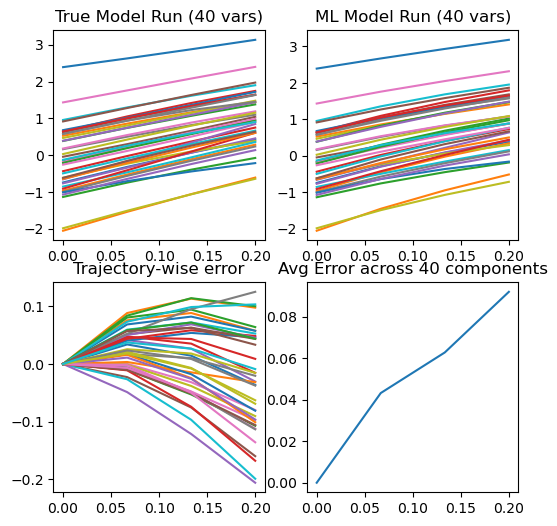

In [259]:
# Time step for the ML model; use the same for the numerical integration
# total time 
t_tot = .2
n_steps = 4
dt = t_tot / n_steps

# Generate a random state
x0 = np.random.randn(40)

x = x0
x_ml = np.zeros((n_steps, 40))
x_ml[0] = x0
for i in range(1, n_steps):
    x = nn._smodel.predict(x.reshape((1, 40, 1)))[0, :, 0]
    x_ml[i] = x

x_phys = solve_ivp(lorenz96, [0, n_steps*dt], x0, t_eval=np.arange(0.0, n_steps*dt, dt)).y.T

time = np.linspace(0, dt * n_steps, x_phys.shape[0])
# plot physical trajectory, nn trajectory and error with time on the x-axis
fig, ax = plt.subplots(2,2, figsize=(6,6))
ax[0,0].plot(time, x_phys)
ax[0,0].set_title("True Model Run (40 vars)")
ax[0,1].plot(time, x_ml)
ax[0,1].set_title("ML Model Run (40 vars)")
ax[1,0].plot(time, x_ml-x_phys)
ax[1,0].set_title("Trajectory-wise error")

ax[1,1].plot(time, np.sqrt(((x_ml - x_phys)**2).mean(axis=1)))
ax[1,1].set_title("Avg Error across 40 components")


In [262]:
y = x_phys[-1,:] # extract values we want to fit with EKI

## Notation
The `Lorenz96` model, named after it's founder, Ed Lorenz, in 1996, is a dynamical system that mimics the state of the atmosphere at 40 equally spaced points around a latitude band. For the earth, the high rotation rate and thin atmosphere result in a system where the dominant direction of motion is East-West, not North-South, and thus the one-dimensional approximation is perhaps to first order somewhat reasonable.  Examining the 40 ordinary differential equations, 
$$ \frac{dx_i}{dt} = (x_{i+1}- x_{i-2})\cdot x_{i-1} - x_i + F$$ 
We see three terms added together. The first is an asymetric interaction term that evolves the state at the current location based on its neighbors; this models the advective dynamics of the atmosphere, while the other two terms, $-x_i$ and $F$ correspond to forcing term. Here we can imagine that $-x_i$ is a dissipation term, e.g., outgoing longwave radiation, while $+F$, is forcing, e.g., solar insolation, that is added to the system. The value $F=8$ is used in our project because it has been shown to generate chaotic behavior.

## EKI

In [263]:
J = 50 # choose number of ensemble members
theta0 = np.random.randn(x0.shape[0], J) # generate initial ensemble of estimates

In [264]:
# map the theta0 ensemble through the numerical model 
# def forward_model(theta, noise=0.01):
#     theta_update = np.zeros_like(theta)
#     for i in range(J):
#         val_noise = np.random.randn(theta.shape[0]) * noise
#         theta_update[:,i] = solve_ivp(lorenz96, [0, n_steps*dt], theta[:,i], t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:] + val_noise
#     return theta_update
def forward_model(theta):
    theta_update = np.zeros_like(theta)
    for i in range(J):
        theta_update[:,i] = solve_ivp(lorenz96, [0, n_steps*dt], theta[:,i], t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:]
    return theta_update 

theta = forward_model(theta0)

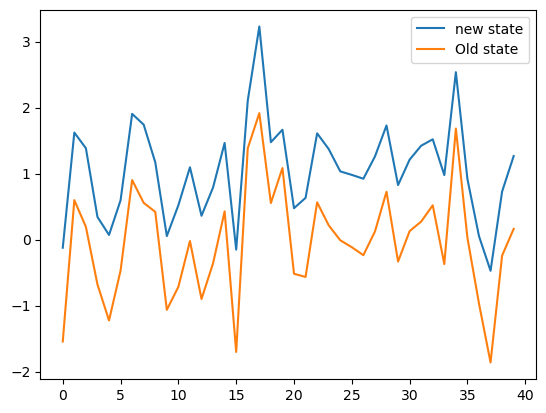

In [265]:
#plt.plot((theta-theta0)[:,0],label="error")
plt.plot(theta[:,0], label = "new state")
plt.plot(theta0[:,0], label= "Old state")
plt.legend()

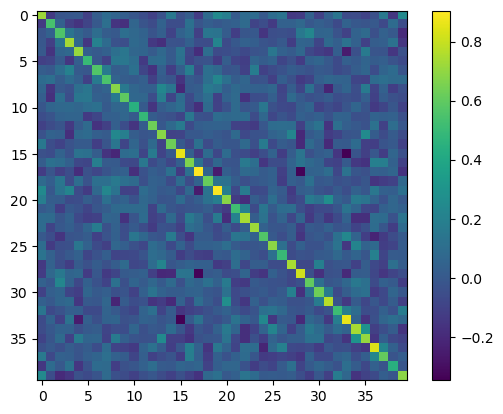

In [266]:

def CGG(Gtheta):
    return np.cov(Gtheta, bias=True)

def CTG(theta, Gtheta):
    """Calculate the cross covariance of the previous state and the next state. 
    Note that for early steps there won't be much correlation"""
    
    num_states = theta.shape[0]
    # https://stackoverflow.com/questions/45134122/numpy-cov-returns-unexpected-output
    return np.cov(np.transpose(theta), np.transpose(Gtheta), bias=True, rowvar=False)[:num_states, num_states:]

plt.imshow(CTG(forward_model(theta0), theta))
plt.colorbar()

In [267]:
# we then define our EKI update step
def EKI_update(theta, Gtheta, y, Gamma, J=J):
    """Update the ensemble of states using the EKI update formula"""
    update = CTG(theta, Gtheta) @ np.linalg.inv(Gamma + CGG(Gtheta)) @ (np.repeat(y, J).reshape(40, J) - Gtheta)
    
    return theta + update, np.linalg.norm(update)
#EKI_update(theta0, theta, y, np.eye(40) * 0.01)

In [268]:
# now we can run the EKI algorithm
iters = 10*40
next_theta = theta0
for i in range(iters):
    next_theta, norm = EKI_update(next_theta, forward_model(next_theta), y, np.eye(40) * .01)
    print(i, norm)
    if norm < 1e-2:
        print(i, norm)
        break

0 57.49785113834236
1 3.839111081343677
2 0.6875913795806824
3 0.4559498136308015
4 0.346933173180082
5 0.28277127609257385
6 0.2404197045739379
7 0.2102198362998741
8 0.18759474856518432
9 0.17001391282053055
10 0.1558949004994405
11 0.14422734294459172
12 0.13444385091309172
13 0.12610234003504134
14 0.11888174216801145
15 0.11252990388676966
16 0.10695319140118463
17 0.1019736171329472
18 0.09749832864802639
19 0.09344402524642631
20 0.08977166927639053
21 0.08640949003644523
22 0.08329619151267617
23 0.08041618188461906
24 0.07775119089169982
25 0.07526605857235842
26 0.07295679332317692
27 0.07078695188441671
28 0.06875831261799975
29 0.06683412980905587
30 0.06502344375677656
31 0.06331268147018193
32 0.06168932724852911
33 0.06015152875991529
34 0.058691877251015864
35 0.05730084585694508
36 0.05597180583493091
37 0.05470138778078364
38 0.053487417109673085
39 0.05232561938767883
40 0.05121371731889218
41 0.05014587759679221
42 0.049119186163828106
43 0.048132646721852655
44 0.0

In [269]:
print(np.linalg.norm(theta0.mean(axis=1) - x0))
np.linalg.norm(next_theta.mean(axis=1) - x0)

5.813571776483793


0.7239338227472593

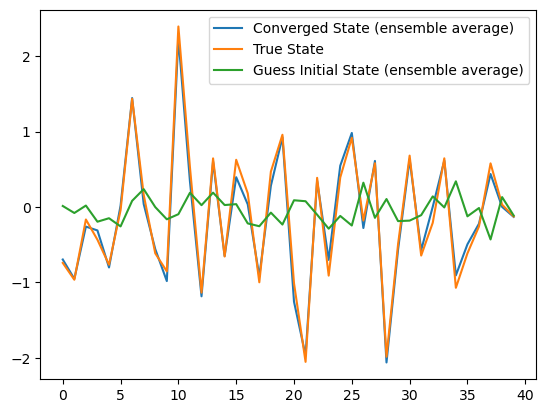

In [270]:
plt.plot(next_theta.mean(axis=1), label="Converged State (ensemble average)")
plt.plot(x0,label="True State")
plt.plot(theta0.mean(axis=1), label="Guess Initial State (ensemble average)")
plt.legend()

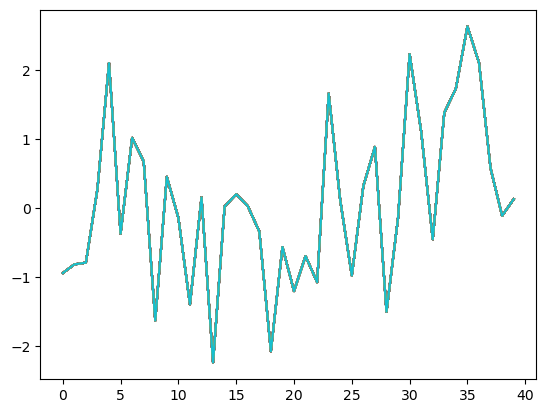

In [249]:
plt.plot(next_theta);

In [ ]:
plt.imshow(next_theta-theta0)
plt.colorbar()

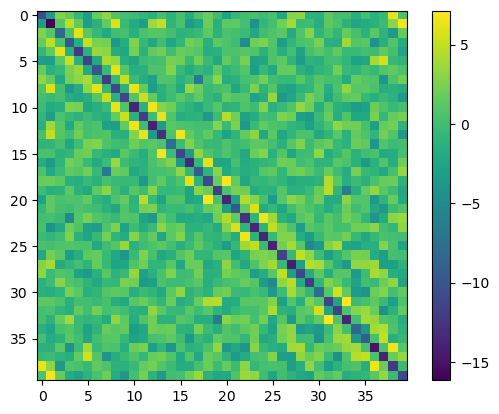

In [66]:
plt.imshow(CTG(theta0, theta) -CGG(theta))
plt.colorbar()

In [251]:
plt.plot(forward_model(forward_model(forward_model(forward_model(x0)))))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## implementation from EKP.jl